**14장 – 합성곱 신경망을 사용한 컴퓨터 비전**

_이 노트북은 14장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

흑백 이미지와 컬러 이미지 출력을 위한 유틸리티 함수:

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 합성곱이란 무엇인가?

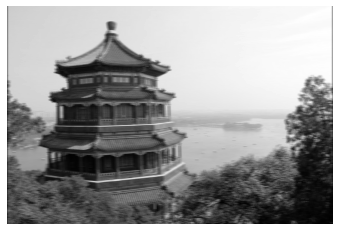

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드합니다.
# 특성을 255로 나누어 0~1의 실수로 변경

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

# 합성곱을 위한 입력형태
# input shape : batch_size, height, width, channels

batch_size, height, width, channels = images.shape

# 2개의 필터를 만듭니다.
# 7*7*3, 2개 필터(0,1)
# (shape=(7, 7, channels, 2)

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선, 첫번째 필터 3열에 1
filters[3, :, :, 1] = 1  # 수평선, 두번째 필터 3행에 1

# 필터를 두 이미지에 적용
# 스트라이드 1, 제로 패딩(same)
# input(= output) shape : batch_size, height, width, channels

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵(수평선)을 그립니다.
plt.axis("off") 
plt.show()

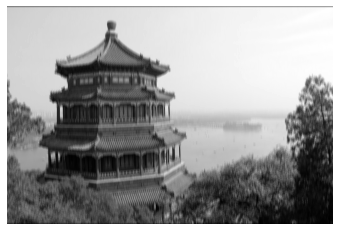

In [ ]:
plt.imshow(outputs[0, :, :, 0], cmap="gray") # 첫 번째 이미지의 첫번째 특성맵(수직선)을 그립니다.
plt.axis("off") 
plt.show()

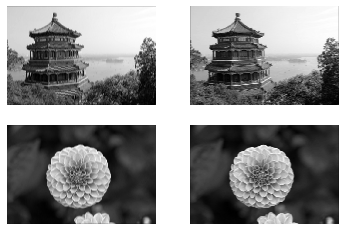

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


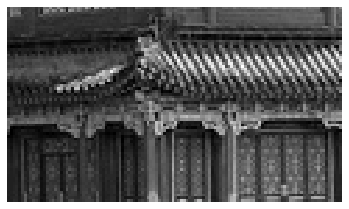

그림 저장 china_vertical


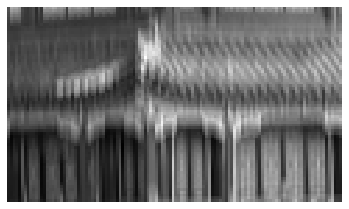

그림 저장 china_horizontal


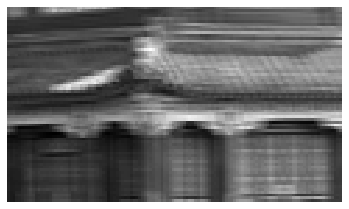

In [ ]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

In [ ]:
crop(images[0, :, :, 0]).shape

(70, 120)

그림 저장 flower_original


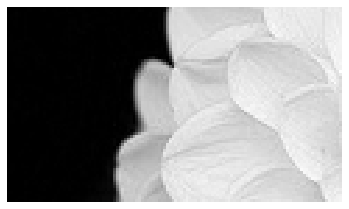

그림 저장 flower_vertical


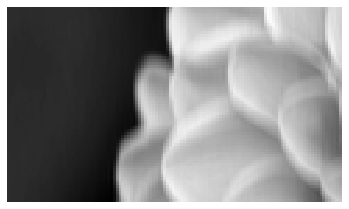

그림 저장 flower_horizontal


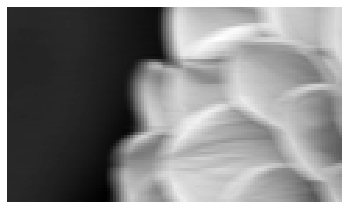

In [ ]:
plot_image(crop(images[1, :, :, 0]))
save_fig("flower_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["flower_vertical", "flower_horizontal"]):
    plot_image(crop(outputs[1, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

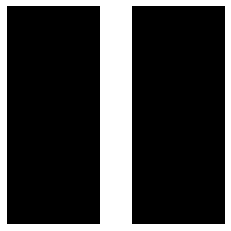

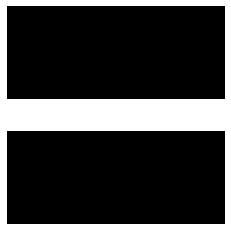

In [ ]:
plot_image(filters[:, :, 0, 0]) # w*h*c*첫번째
plt.show()
plot_image(filters[:, :, 0, 1]) # w*h*c*두번째
plt.show()

## 합성곱 층

`keras.layers.Conv2D()`를 사용해 2D 합성곱 층을 만들어 보죠:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# 7*7 크기의 2개 필터, 스트라이드 1, same 패딩, ReLU 활성화

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

두 개의 테스트 이미지로 이 층을 호출합니다:

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape 
# 배치사이즈(이미지 2개), w,h, 필터수(깊이/채널)

TensorShape([2, 427, 640, 2])

출력은 4D 텐서.

차원은 배치 크기, 높이, 너비, 채널.

2개의 이미지를 입력으로 사용했기 때문에 첫 번째 차원(배치 크기)는 2.
출력 특성맵의 높이와 너비

 `padding="SAME"`와 `strides=1`로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 동일(427×640). 
 
이 합성곱 층은 2개의 필터를 사용. 따라서 마지막 차원의 크기는 2. 즉 입력 이미지마다 "2개의 특성맵"이 출력.

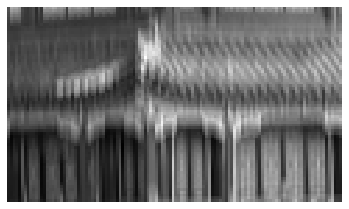

In [ ]:
plot_image(crop(outputs[0,:,:,0]))
plt.show()

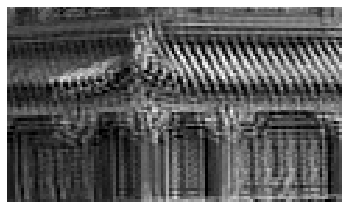

In [ ]:
plot_image(crop(conv_outputs[0,:,:,0]))
plt.show()

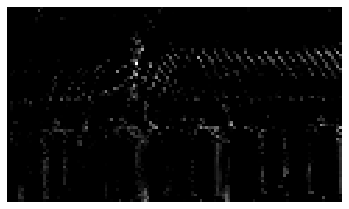

In [ ]:
plot_image(crop(conv_outputs[0,:,:,1]))
plt.show()

필터는 초기에 랜덤하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지합니다. 이미지마다 출력된 2개의 특성맵을 확인해 보죠:

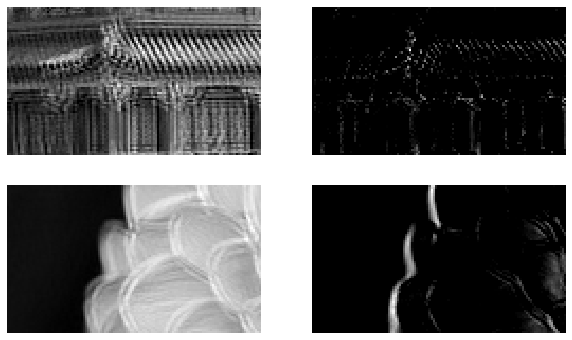

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

필터가 초기에 랜덤하게 초기화되엇지만 두 번째 필터는 에지를 감지한 것처럼 보입니다. 랜덤하게 초기화된 필터는 종종 이런 식으로 동작합니다. 에지 감지는 이미지 처리에 매우 유용하기 때문에 운이 좋습니다.

원한다면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 있습니다(합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습하기 때문에 실제로는 수동으로 필터와 편향을 지정할 필요가 거의 없습니다):

In [ ]:
conv.set_weights([filters, np.zeros(2)])

이제 이 층을 동일한 두 이미지에서 다시 호출해 보죠. 그다음 출력 특성맵이 (앞에서처럼) 수직선과 수평선을 부각하는지 확인해 보겠습니다:

In [ ]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

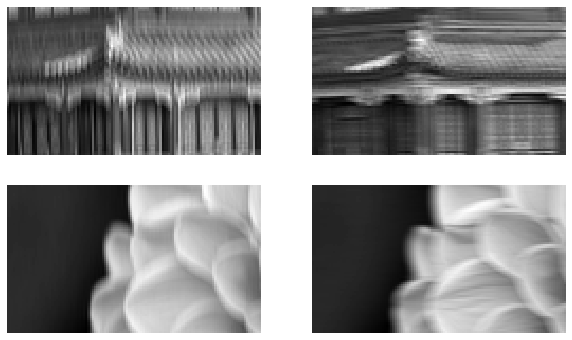

In [ ]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

[메모리 요구사항]

합성곱 층이 많은 양의 RAM을 필요로 한다

예시: 5*5 필터, 스트라이드 1, same 패딩, 150*100사이즈 RGB 이미지, 특성 맵 200개를 만드는 합성곱 층

파라미터수 : (5*5*3+1)*200=15,200개
200개의 특성맵마다 150*100개의 뉴런, 각 뉴런은 5*5*3개의 입력에 대한 가중치 합 계산

약 2억개의 실수곱셈 필요

200 x 150 x 100 x 32(32비트 부동소수, 특성맵표현) = 9천 6백만 비트(약 12MB)

100개의 샘플인 경우 1.2GB RAM 사용

정방향 계산 값을 역방향계산위해 보존해야함

메모리 부족시 : 미니배치 크기 축소, 스트라이드 크게, 몇개층 삭제, 32비트 대신 16비트 부동소수사용, 여러 장치에 CNN 분산

## VALID vs SAME 패딩

In [ ]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [ ]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [ ]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

`"SAME"` 패딩을 사용하는 것은 `manual_same_padding()`을 사용해 수동으로 패딩하고 `"VALID"` 패딩을 사용하는 것과 동일합니다(혼동될 수 있지만 `"VALID"` 패딩은 전혀 패딩을 하지 않는다는 뜻입니다):

In [ ]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# 풀링 층

입력이미지에 대한 축소본 만들기

풀링층 생성의 몇가지 조건

- 이전과 동일하게 크기, 스트라이드, 패딩 유형 지정
- 풀링 뉴런은 가중치가 없음
- 최대 또는 평균과 같은 합산 함수를 사용해 입력값을 더한다.

장점:
- 계산량, 메모리 사용량, 파라미터 수를 감소
- 최대 풀링은 작은 변화에 대해 일정 수준의 불변성을 만들어 준다. (회전과 확대, 축소에 대해 약간의 불변성 제공)

## 최대 풀링

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장 china_max_pooling


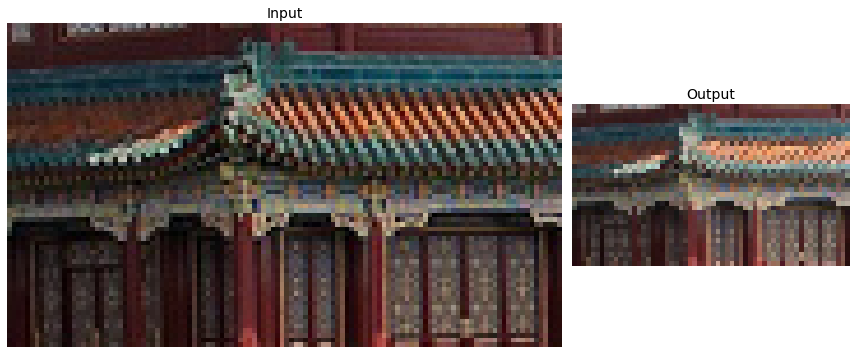

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()
# 사이즈 줄고, 전체적인 구조는 유지

## 깊이 방향(depth-wise) 풀링

In [ ]:
# tf.nn.max_pool 이용해서 구현
# 깊이 방향으로 색상에 변화
# 회전에 대한 여러 필터 사용시 회전에 불변성 학습

class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size), # 배치, 높이, 너비차원을 따라 커널과 스트라이드가 1
                              strides=(1, 1, 1, self.pool_size), # 마지막값이 채널(깊이)
                              padding=self.padding)

In [ ]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

또는 `Lambda` 층을 사용합니다:

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

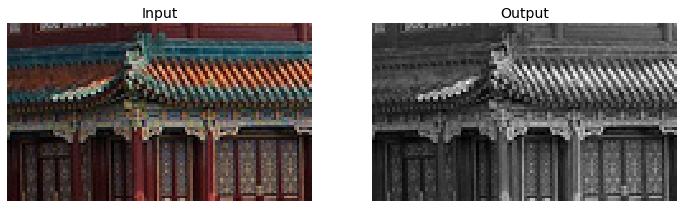

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

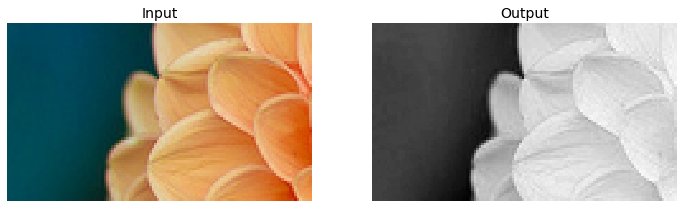

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[1])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[1, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

## 평균 풀링

In [ ]:
# 평균값으로 풀링
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

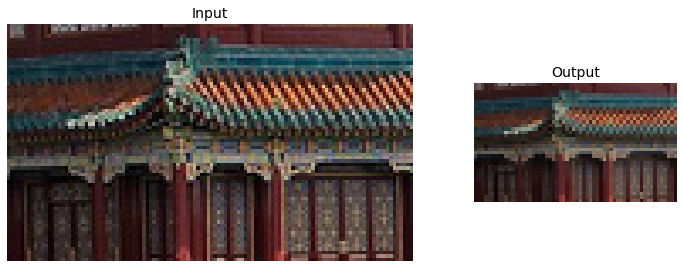

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")

plt.show()

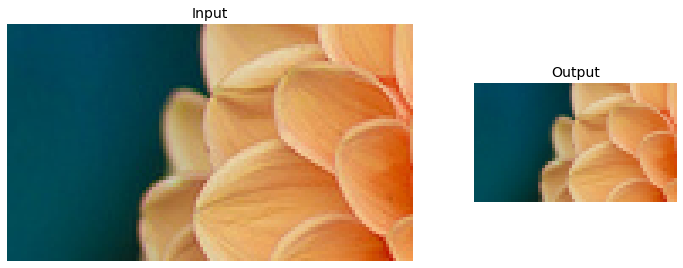

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[1])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[1])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")

plt.show()

## 전역 평균 풀링

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

# input : (batch_size, rows, cols, channels)
# output : (batch_size, channels)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [ ]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

# CNN으로 패션 MNIST 문제 풀기

In [ ]:
# 데이터 로딩
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# 255로 나누어서 0~1로 변경 가능
# 여기서는 standard scaling으로 표준화

X_mean = X_train.mean(axis=0, keepdims=True) # 훈련데이터의 평균
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std # 훈련데이터의 평균 분산 사용
X_test = (X_test - X_mean) / X_std  # 훈련데이터의 평균 분산 사용

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
from functools import partial

# partial : 파라메터만 미리 정해준 또 다른 함수를 생성

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# 이미지가 아주 크지 않아서 64개의 큰 필터 (7 x 7)와 스트라이드 1을 사용

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2), # 풀링 크기가 2인 최대 풀링 층을 추가하여 공간 방향 차원을 절반으로 줄인다.
    # 동일한 구조를 두번 반복, 이미지가 클 때는 이러한 구조를 더 많이 반복이 가능함
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    # CNN이 출력층에 다다를수록 필터 개수가 늘어남
    # 저수준(작은 동심원, 수평선)의 개수는 적지만 이를 연결하여 고수준 특성을 만든다.
    # 풀링층 다음에 필터수를 두배로 늘린다
    # 풀링층이 공간 방향 차원을 반으로 줄이프로 이어지는 층에서 특성 맵 개수를 두배로 늘린다
    # 밀집 네트워크는 샘플의 특성으로 1D배열을 기대하므로 입력을 일렬로 펼쳐야 함.
    keras.layers.Flatten(),
    # 두 개의 은닉층과 하나의 출력층으로 구성된 완전 연결 네트워크
    keras.layers.Dense(units=128, activation='relu'),
    # 밀집 층 사이에 과대적합을 줄이기 위해 50%의 드롭아웃 비율을 가진 드롭아웃 층 추가
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 18s 8ms/step - loss: 0.7062 - accuracy: 0.7529 - val_loss: 0.3767 - val_accuracy: 0.8638
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4236 - accuracy: 0.8579 - val_loss: 0.3307 - val_accuracy: 0.8814
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3660 - accuracy: 0.8758 - val_loss: 0.3044 - val_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3368 - accuracy: 0.8871 - val_loss: 0.2830 - val_accuracy: 0.8942
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3073 - accuracy: 0.8963 - val_loss: 0.2891 - val_accuracy: 0.8990
Epoch 6/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2899 - accuracy: 0.9004 - val_loss: 0.3051 - val_accuracy: 0.8870
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2760 - accuracy: 0.9056 - val_loss: 0.2755 - val_ac

In [ ]:
score = model.evaluate(X_test, y_test)
score

313/313 [==============================] - 1s 4ms/step - loss: 0.2969 - accuracy: 0.8968


[0.2968931496143341, 0.8967999815940857]

In [ ]:
X_new = X_test[:10] # 새로운 이미지처럼 사용
y_pred = model.predict(X_new)
y_pred
# 각 클래스에 대한 확률값 출력

array([[0.00000000e+00, 7.71801294e-35, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.55471776e-15, 5.89803743e-37, 5.90067145e-07,
        5.55490279e-34, 9.99999404e-01],
       [5.77004471e-08, 2.32049705e-16, 9.99180377e-01, 1.29467020e-10,
        3.98140895e-04, 8.21604944e-25, 4.21481789e-04, 2.62620608e-26,
        5.56566444e-14, 7.96150621e-25],
       [2.19283649e-27, 1.00000000e+00, 3.03813389e-24, 1.82874248e-18,
        1.82825747e-22, 0.00000000e+00, 3.50964651e-24, 0.00000000e+00,
        8.01628100e-37, 1.55686824e-38],
       [3.71248149e-27, 1.00000000e+00, 2.70940638e-25, 1.56955588e-18,
        6.88073127e-25, 0.00000000e+00, 1.36499758e-24, 0.00000000e+00,
        2.01552996e-37, 0.00000000e+00],
       [4.91865940e-05, 5.43113238e-16, 1.62425946e-04, 5.65695153e-08,
        1.61958509e-03, 1.26301525e-18, 9.98168707e-01, 3.26382335e-19,
        3.58633331e-11, 2.04739626e-17],
       [1.23488728e-22, 1.00000000e+00, 1.32937287e-20, 1.23780164e-15,
   

슬라이드 보기

5월 19일 여기서부터

## ResNet-34

-- 2015년 우승

In [ ]:
# 케라스로 resnet-34구현
# 이 코드는 [그림 14-18]을 구현한 것 (p. 571)

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

# 잔차 유닛 만들기, 하나의 클래스로 만들어 층처럼 사용
# main layers, skip layer
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [    # 메인
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []  # 스킵
        if strides > 1: # skip_layer는 스트라이드가 1보다 큰경우만 필요
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

# call()메소드 : 입력을 main_layer와 skip_layer에 통과 시킨후 두출력을 더해 활성화 함수 적용

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers: # 메인
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers: # 스킵
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)  # 출력을 더해 활성화함수 통과

In [ ]:
# 시퀀셜로 모델 구축 : 연속되어 길게 연결된 층

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64

# for문으로 모델에 잔차유닛 추가하는 반복문
# 처음 3개는 64개, 다음 4개는 128개의 필터

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: # RU 설정
    strides = 1 if filters == prev_filters else 2  # 필터수가 이전 RU와 동일하면 스트라이더를 1로 설정 아니면 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters  # 필터 업데이트
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()
# 이 코드에서 조금 복잡한 부분은 ResidualUnit층을 더하는 반복 루프.
# 이 코드를 통해 ILSVRC 2015년 대회 우승 모델이 되었음.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

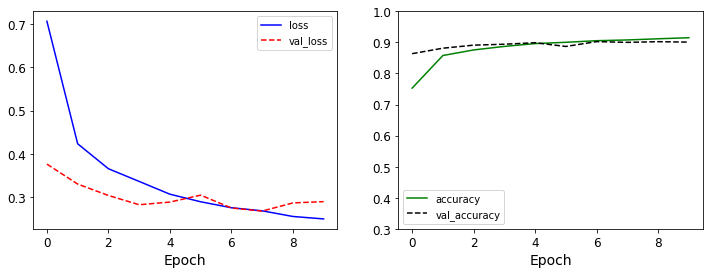

In [ ]:
# 시각화

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

## 사전 훈련된 모델 사용하기

In [ ]:
# 이미지넷 데이터넷에서 사전훈련된 ResNet-50 모델을 로드
model = keras.applications.resnet50.ResNet50(weights="imagenet") # 이미지넷으로 훈련된 가중치 다운로드

102981632/102967424 [==============================] - 0s 0us/step


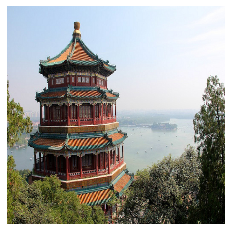

In [ ]:
# 사전훈련된 모델을 사용하려면 이미지가 적절한 크기인지 확인: 224*224
# 이미지의 크기가 다르면 tf.image.resize()함수로 적재한 이미지의 크기 변경
# 가로 세로 비율이 유지 되지 않음
# tf.image.crop_and_resize() : 비율로 자르고 resize

images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

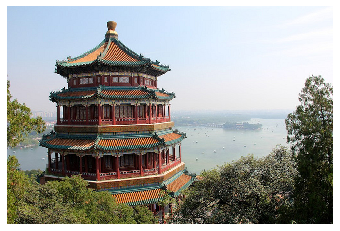

In [ ]:
plot_color_image(images[0])
plt.show()
# 원본 이미지

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


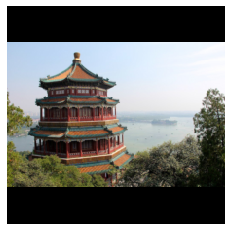

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
# 왜곡없이 종횡비를 동일하게 유지하여 이미지를 대상 폭과 높이로 조정
# 대상 치수가 이미지 치수와 일치하지 않으면 이미지 크기가 조정 된 다음 요청된 치수와 일치하도록 0으로 채워집니다.

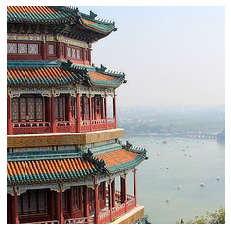

In [ ]:
# 이미지를 중앙에서 자르거나 0으로 균등하게 채워 이미지를 대상 폭과 높이로 조정
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

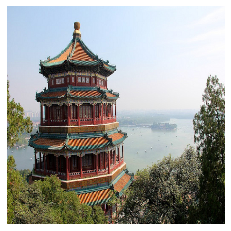

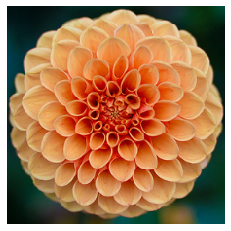

In [ ]:
china_box = [0, 0.03, 1, 0.68]
# china_box = [0, 0, 1, 1]
flower_box = [0.19, 0.26, 0.86, 0.7]
# [y1, x1, y2, x2]
# y * (image_height - 1)
# tf.image.crop_and_resize( image, boxes, box_indices, crop_size)
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [ ]:
# 0~255 입력을 받아서 전처리
# 앞에서 0~1로 변경하여서 다시 255를 곱한다

inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# 사전 훈련된 모델을 사용하여 예측을 수행
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape
# 이미지와 1000개의 클래스에 대한 확률

(2, 1000)

In [ ]:
# 각 이미지에 대해 최상위 K개의 예측을 담은 리스트 반환
# 각 예측은 클래스 아이디, 이름, 확률을 포함하는 튜플

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()
    
# 1000개의 클래스중 top=3
# 첫번째 이미지정답 : monastery, 두번째 이미지 정답 : daisy

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



Resnet 여러버전

GoogLenet 변형(inception-v3, Xception)

VGG 모델 여러버전

경량버전 : MobileNet

## 전이 학습을 위한 사전 훈련된 모델

이미지넷에 없는 이미지 클래스를 감지하기 위해 사전 훈련 모델 사용

In [ ]:
# 충분하지 않은 훈련데이터 : 사전훈련모델의 하위층 사용

import tensorflow_datasets as tfds

# 데이터를 적재
# with_infor=True : 데이터셋에 대한 정보 제공, 데이터셋 크기와 클래스 이름

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [ ]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [ ]:
class_names = info.features["label"].names
# 클래스 이름 확인
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes
n_classes

5

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

**경고:** TFDS의 split API는 책이 출간된 후에 바뀌었습니다. [새로운 split API](https://www.tensorflow.org/datasets/splits)(S3 슬라이싱 API)는 사용하기 훨씬 간단합니다:

In [ ]:
# 데이터 분할
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

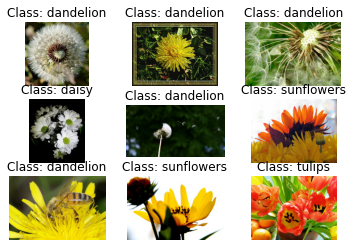

In [ ]:
# 이미지 출력해보기 plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

기본 전처리:

In [ ]:
# 224X224 크기 이미지를 기대하므로 크기를 조정
# xception.preprocess_input : 전처리

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

조금 더 정교한 전처리 (하지만 훨씬 많은 데이터 증식을 할 수 있습니다):

In [ ]:
# 훈련 세트를 섞은 후, 이 전처리 함수들을 데이터셋에 모두 적용하고 배치 크기를 지정하고 프리페치를 적용
# tf.image.random.crop()등을 이용해 데이터 증식 가능

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) 
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) 
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 배치 사이즈
# 셔플
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()

# 훈련 속도를 더 빠르게
# prefetch(1)을 호출하면 데이터셋은 항상 한 배치가 미리 준비되도록

train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

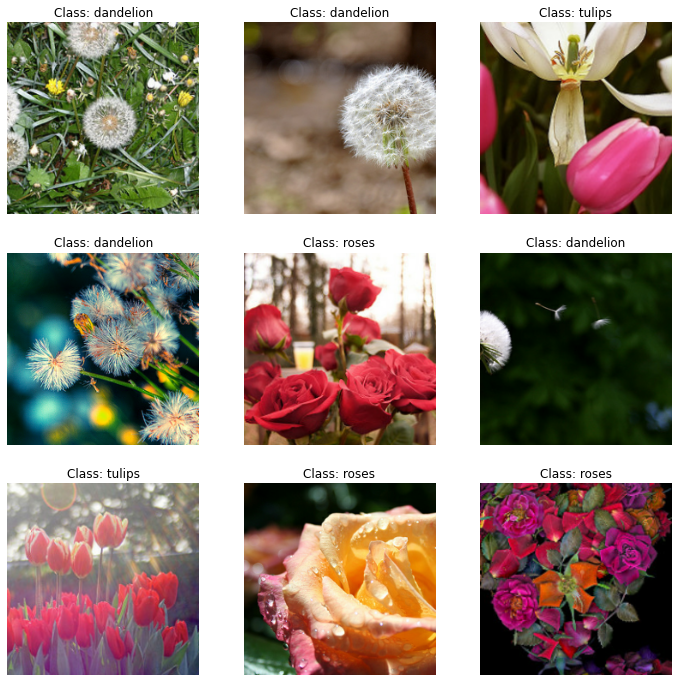

In [ ]:
# train에 있는 데이터 보기

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

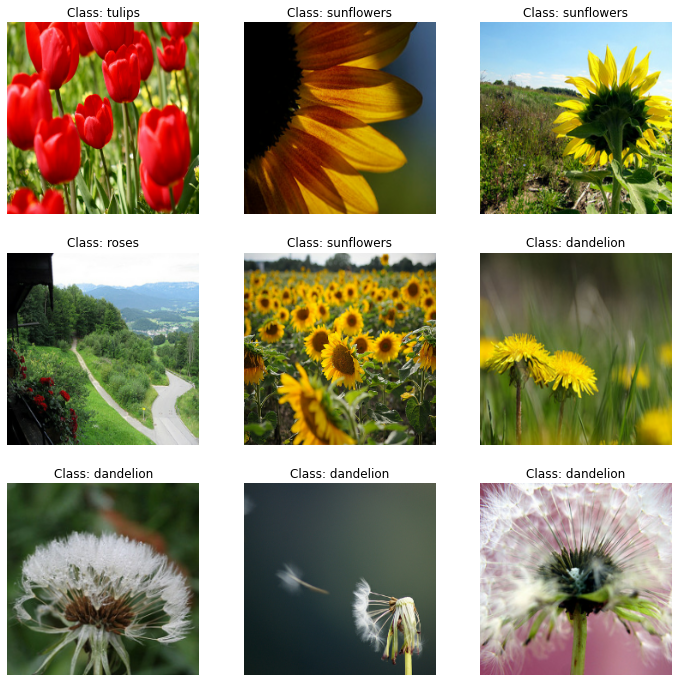

In [ ]:
# 테스트 데이터 보기

plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
# Xception 모델 로드
# include_top=False로 지정하여 네트워크의 최상층에 해당하는 전역 평균 풀링 층과 밀집 출력 층은 제외

base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# 새로운 전역풀링층 추가
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# 새롭게 클래스 마다 하나의 유닛, 소프트맥스 활성화
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# 케라스 모델 클래스 생성
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_88
13 block2_pool
14 batch_normalization_72
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_89
23 block3_pool
24 batch_normalization_73
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_90
33 block4_pool
34 batch_normalization_74
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [ ]:
# 훈련 초기에는 사전훈련된 층의 가중치를 동결.
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)

# 모델 컴파일

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 37s 367ms/step - loss: 1.4720 - accuracy: 0.7925 - val_loss: 1.4752 - val_accuracy: 0.8070
Epoch 2/5
86/86 [==============================] - 31s 358ms/step - loss: 0.6576 - accuracy: 0.8914 - val_loss: 0.9815 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 31s 360ms/step - loss: 0.3623 - accuracy: 0.9248 - val_loss: 0.8554 - val_accuracy: 0.8732
Epoch 4/5
86/86 [==============================] - 31s 360ms/step - loss: 0.2582 - accuracy: 0.9335 - val_loss: 0.7072 - val_accuracy: 0.8842
Epoch 5/5
86/86 [==============================] - 31s 360ms/step - loss: 0.2029 - accuracy: 0.9440 - val_loss: 0.7266 - val_accuracy: 0.8732


In [ ]:
# 검증 정확도가 어느정도 선에 머물러서 더 나아지지 않는다면 새로운 층이 잘 훈련되었음
# 모든 층의 가중치 동결을 해제하고 다시 훈련
# 사전훈련된 가중치가 훼손되는 것을 피하기 위해 훨씬 작은 학습률을 사용

for layer in base_model.layers:
    layer.trainable = True  # 사전학습 가중치 동결 해제

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,  # 작은 학습률
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 61s 654ms/step - loss: 0.3505 - accuracy: 0.8881 - val_loss: 0.5942 - val_accuracy: 0.8346
Epoch 2/40
86/86 [==============================] - 56s 653ms/step - loss: 0.1274 - accuracy: 0.9622 - val_loss: 0.3924 - val_accuracy: 0.8713
Epoch 3/40
86/86 [==============================] - 57s 663ms/step - loss: 0.0621 - accuracy: 0.9800 - val_loss: 0.3522 - val_accuracy: 0.8952
Epoch 4/40
86/86 [==============================] - 57s 669ms/step - loss: 0.0572 - accuracy: 0.9855 - val_loss: 0.2722 - val_accuracy: 0.9228
Epoch 5/40
86/86 [==============================] - 57s 667ms/step - loss: 0.0347 - accuracy: 0.9866 - val_loss: 0.2827 - val_accuracy: 0.9283
Epoch 6/40
86/86 [==============================] - 57s 667ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.3221 - val_accuracy: 0.9191
Epoch 7/40
86/86 [==============================] - 58s 672ms/step - loss: 0.0152 - accuracy: 0.9942 - val_loss: 0.2947 - val_accuracy: 0.9265

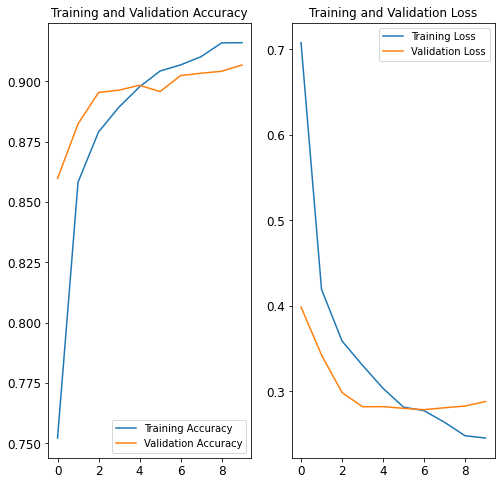

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 손실률과 정확률 출력

슬라이드 14-3

# 분류와 위치 추정

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

#전역평균풀링

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)

# 위치 추적위한 4개의 dense 층

loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
# mse로 훈련
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # 어떤 것을 중요하게 생각하느냐에 따라
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 6s 630ms/step - loss: 1.3813 - dense_5_loss: 1.6242 - dense_6_loss: 0.4098 - dense_5_accuracy: 0.1562 - dense_6_accuracy: 0.2188
Epoch 2/2
5/5 [==============================] - 3s 655ms/step - loss: 1.3013 - dense_5_loss: 1.5382 - dense_6_loss: 0.3537 - dense_5_accuracy: 0.3187 - dense_6_accuracy: 0.2625


## mAP(Mean Average Precision)

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

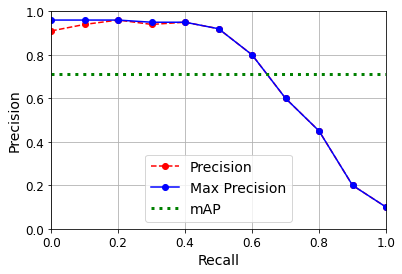

In [ ]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

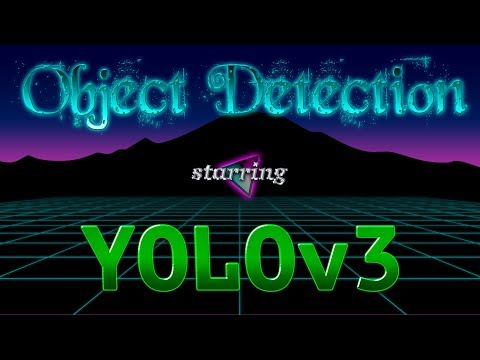

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPU2HistivI')

전치 합성곱:

In [ ]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

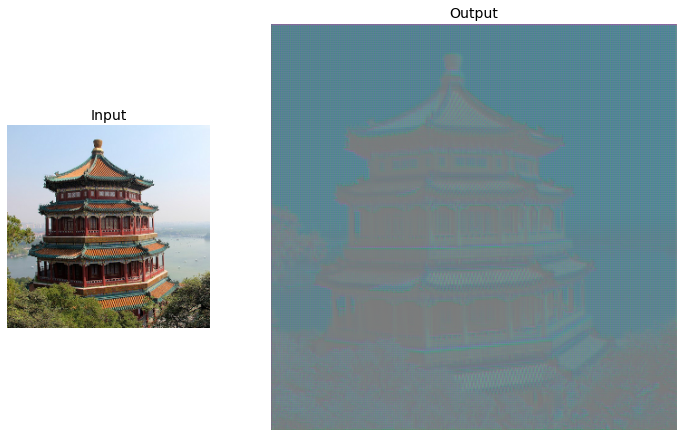

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

In [ ]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

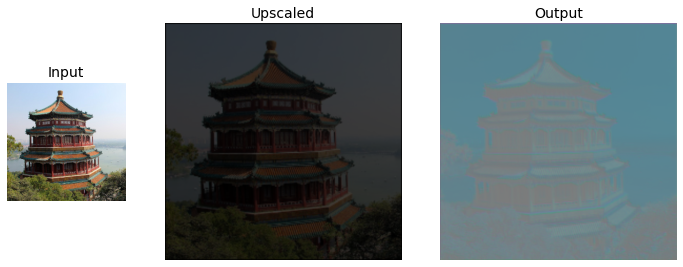

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # 첫 번째 이미지 출력 그리기
ax3.axis("off")
plt.show()

In [ ]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# 연습문제

## 1. to 8.

부록 A 참조.

## 9. MNIST에서 높은 정확도를 내는 CNN 만들기
_연습문제: 자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도를 달성해보세요._

다음 모델은 2개의 합성곱 층과 1개의 풀링 층을 사용합니다. 그다음 25% 드롭아웃하고 이어서 밀집 층을 놓고 50% 드롭아웃을 다시 적용합니다. 마지막에 출력층을 놓습니다. 이 모델은 테스트 세트에서 약 99.2% 정확도를 냅니다. 이 모델은 [MNIST 캐글 경연대회](https://www.kaggle.com/c/digit-recognizer/)에서 상위 20위 안에 포함되는 수준입니다(Chris Deotte가 [이 포스트](https://www.kaggle.com/c/digit-recognizer/discussion/61480)에서 설명했듯이 테스트 세트에서 훈련된 것 같은 99.79%보다 높은 정확도를 가진 모델은 무시합니다). 더 높일 수 있을까요? 테스트 세트에서 99.5~99.7% 사이의 정확도를 달성하려면 이미지 증식, 배치 정규화를 추가하고 1-cycle 같은 학습률 스케줄을 사용하고 앙상블 모델을 만들어야 합니다.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.1973 - accuracy: 0.9403 - val_loss: 0.0445 - val_accuracy: 0.9882
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0800 - accuracy: 0.9765 - val_loss: 0.0409 - val_accuracy: 0.9888
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0609 - accuracy: 0.9814 - val_loss: 0.0330 - val_accuracy: 0.9912
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0348 - val_accuracy: 0.9910
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0408 - accuracy: 0.9868 - val_loss: 0.0361 - val_accuracy: 0.9902
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0367 - accuracy: 0.9881 - val_loss: 0.0345 - val_accuracy: 0.9920
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.0372 - val_accuracy

[0.029317684471607208, 0.9925000071525574]

## 10. 전이 학습을 사용한 대규모 이미지 분류

_연습문제: 다음 단계를 따라 전이 학습을 사용해 대규모 이미지 분류를 수행해보세요:_

* _클래스마다 최소한 100개의 이미지가 들어 있는 훈련 세트를 만드세요. 예를 들어 위
치에 따라(해변, 산, 도심 등) 자신의 사진을 분류하거나, 기존의 데이터셋(예를 들
면, 텐서플로 데이터셋)을 사용할 수도 있습니다._
* _이를 훈련 세트와 검증 세트, 테스트 세트로 나눕니다._
* _적절한 전처리 연산과 선택적으로 데이터 증식을 수행하는 입력 파이프라인을 만듭
니다._
* _이 데이터셋에서 사전훈련된 모델을 세부 튜닝합니다._

Flowers 예제를 참고하세요.

## 11.
_연습문제: 텐서플로의 [스타일 전이 튜토리얼](https://homl.info/styletuto)을 살펴보세요. 딥러
닝을 사용해 재미있는 그림을 생성할 수 있습니다._

코랩을 사용해 튜토리얼을 따라해 보세요.